# All SAMI3 keograms and maps and Data Analysis used in the Sim Storm Paper

## Imports

In [1]:
# import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# from scipy.io import readsav
# import pymap3d as pm
# import glob
import datetime
# from aetherpy.io import read_routines
# from math import cos, radians, sin, sqrt
from scipy import spatial, signal

# from spacepy.coordinates import Coords
# from spacepy.time import Ticktock
# import fnmatch
# 
import gc

import sys
from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d, griddata

# %matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [2]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 

dtime_sim_start = datetime.datetime(2011,5,20)

t_step_minutes = 5 # minutes


plot_start_delta  = 2  # hours before storm onset to start making plots. set to -1 to run the whole time
plot_end_delta    = 6  # hours after storm onset to end plots. Set to -1 to run for the whole time

data_in_path = '/home/axb170054/scratch/pickles/SimStormPaper/simstorm_sami_files/'

lon_keos = [-178, -150, -100, -30, 50, 100, 150]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 


# threading options. This can be set to False and it is ok. Don't set higher than the number of cores on your machine.
thread = True
num_pool_workers = 40

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru

glons_to_plot = 10 #number of field lines you want to plot. Not necessary. You can set to none if you want to plot stuff yourself
alts_to_plot = 10 # Number of altitudes to make maps & keos of. 


locut = 100 #minutes
hicut = 30 #minutes


In [3]:
diff_vs = [1,2,5,10,20] # +/- lims for the diff plots. This will save a lot of time later, I think. 
# These will be looped thru when making 'diff' plots.


In [4]:
sami_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/keos/"
sami_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/maps/"

In [5]:
cols = ['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

# above is all cols (that I care about), below is just edens.

# cols = ['edens']

Available columns (for now) are:

['edens', 'hplusdens', 'oplusdens', 'noplusdens', 'o2plusdens', 'heplusdens', 'n2plusdens', 'nplusdens', 'hdens', 'odens', 'nodens', 'o2dens', 'hedens', 'n2dens', 'ndens']

## Constants:

## Functions

In [6]:
def read_sami_data():
    
    """
    
    return data_dict[col][number_time, lat, lon, alt]
    
    
    """
    
    
    #times
    times = np.loadtxt(data_in_path + 'times', dtype = str, delimiter=',')
    #format
    times = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in times]
    
    hrs = [(t - dtime_storm_start)/pd.Timedelta(1, 'hour') for t in times]
    
    #grid
    lats = np.loadtxt(data_in_path + 'out-lats', delimiter=',')
    lons = np.loadtxt(data_in_path + 'out-lons', delimiter=',')
    alts = np.loadtxt(data_in_path + 'out-alts', delimiter=',')
    
    data_dict = {}
    
    for col in cols:
        data_dict[col] = np.loadtxt(data_in_path + 'preds-' + col, delimiter= ',').reshape(len(times),len(lats), len(lons), len(alts))
    
    
    return np.array(times), hrs, lats, lons, alts, data_dict

In [7]:
def make_filter(params = None, order = 2):
    # Define the cutoff frequencies
    lowcut = 1/(locut/60)  # 100 minutes in units of sample^-1
    highcut = 1/(hicut/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(order, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series, axis = 0)

    return filtered_data



In [8]:
def UT_from_Storm_onset(dtime):
    """input a datetime
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(dtime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = '-' + str(np.abs(int(hrs))).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

In [11]:
def make_a_plot(data, x_label = None, y_label = None, title = None, 
                cbar_lims = None, cbar_label = None, save_or_show = 'show', 
                fname = None, plot_extent = None):
    ##Clean inputs:
    if cbar_lims == None:
        cbar_lims = [ np.min(data), np.max(data) ]
        
    ## Plots have to be done in weird ways. this will make calling things easier...
    ismap = False
    iskeo = False
        
    if plot_extent == None:
        if data.shape == (65,75):
            plot_extent = [-180, 180, np.min(lats), np.max(lats)]
            x_label = 'Longitude(deg)'
            y_label = 'Latitude (deg)'
            ismap = True
        if data.shape ==  (144,65):
            plot_extent = [np.min(hrs), np.max(hrs), np.min(lats), np.max(lats)]
            x_label = 'Hours from storm onset'
            y_label = 'Latitude (deg)'
            iskeo = True
    
    
    
    
    
    if ismap:
        
        # Need to get the data from -180-180 not 0-360...
        
            ## Fix the ordering of the longitudes and go from -180-180 not 0->360 
        newlons_for_order = []
        newlons = np.zeros_like(lons)
        for ilon in lons:
            oldlon = ilon
            if oldlon <=180:
                newlons_for_order.append(int(oldlon))

            else:
                newlons_for_order.append(int(oldlon)-360) 

        new_lons_sorted = np.sort(newlons_for_order)
        new_order = np.array([newlons_for_order.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))]) 
        
        fig, ax = plt.subplots(figsize = (10,5))
        world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
        
        p = ax.imshow(data[:,new_order], extent = plot_extent, vmin = cbar_lims[0], vmax=cbar_lims[1], origin = 'lower', 
                       aspect = 'auto', interpolation= 'bicubic', interpolation_stage='rgba', label = cbar_label, zorder = 10,
                     alpha = 0.9)
        fig.colorbar(p, label = cbar_label)
        
    elif iskeo:
        plt.figure(figsize = (10,5))
        plt.imshow(data.T, extent = plot_extent, vmin = cbar_lims[0], vmax=cbar_lims[1], origin = 'lower', aspect = 'auto',
              interpolation= 'bicubic', interpolation_stage='rgba', label = cbar_label)
        plt.colorbar()
    
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    
    plt.title(title)
    
    
    

    if save_or_show == 'show':
        plt.show()
        plt.close()
        if fname:
            print(fname)
    elif save_or_show == 'save':
        if not fname:
            raise ValueError('plot save path must be given!')
        else:
            # fname = fname.replace(' ','')
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                try:
                    directory_list = os.path.join(fname).split('/')[:-1]
                    os.makedirs('/'+os.path.join(*directory_list))
                    plt.savefig(fname)
                except FileExistsError:
                    time.sleep(2) # sometimes when we make too many plots in the same directory, it fails. this fixes that.
                    try:
                        plt.savefig(fname)
                    except FileNotFoundError:
                        time.sleep(2)
                        plt.savefig(fname)

            except:
                print(fname)
                raise ValueError

    
      

    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)
    plt.close()


In [12]:
def call_maps(col, real_time, real_alt, figtype = 'all', save_or_show = 'show'):
    
    itime = np.where(times == real_time)[0][0]
    ialt = np.where(alts == real_alt)[0][0]
    
    raw = data_dict[col][itime,:,:,ialt]
    fit = fits[col][itime,:,:,ialt]
    
    diff = 100*(raw - fit)/fit
    
    fname = os.path.join(sami_map_save_path, col, 'plot_type', str(int(real_alt)) , str(itime).rjust(3,'0') + '.png')
    
    ut_diff = UT_from_Storm_onset(real_time)
    
    plotted = False
    
    if figtype == 'all' or 'raw' in figtype:
        title = '%s at %s from storm onset \n %i km altitude' %(col, ut_diff, int(real_alt))
        make_a_plot(raw, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','raw'))
        plotted = True
    
    if figtype == 'all' or 'bandpass' in figtype:
        title = '%s at %s from storm onset \n %i km altitude' %(col, ut_diff, int(real_alt))
        make_a_plot(fit, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','bandpass'))
        plotted = True
        
    if figtype == 'all' or 'diff' in figtype:
        title = '%s at %s from storm onset \n %i km altitude' %(col, ut_diff, int(real_alt))
        for v in diff_vs:
            make_a_plot(diff, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','filt-' +str(v)), 
                    cbar_label='% over background', cbar_lims=[-v,v])
    
        plotted = True
    plt.close('all')
    gc.collect()
    if not plotted:
        raise ValueError("no plots were made. options are 'diff', 'bandpass', 'raw', or 'all', you gave %s" %(figtype))
    
    
def thread_call_maps(arg_arr):
    call_maps(arg_arr[0], arg_arr[1], arg_arr[2], figtype=arg_arr[3], save_or_show=arg_arr[4])

In [13]:
def call_keos(col, real_lon, real_alt, figtype = 'all', save_or_show = 'show', cbar_lims = None):
    
    ilon = np.argmin(np.abs(lons - real_lon))
    ialt = np.argmin(np.abs(alts - real_alt))
    
    real_lon = lons[ilon]
    real_alt = alts[ialt]
    
    raw = data_dict[col][:,:,ilon,ialt]
    fit = fits[col][:,:,ilon,ialt]
    
    diff = 100*(raw - fit)/fit
    
    fname = os.path.join(sami_keo_save_path, col, 'plot_type', str(int(real_alt)) , 'lon' + str(int(real_lon)) + '.png')
    

    plotted = False
    
    if figtype == 'all' or 'raw' in figtype:
        title = '%s at %i (deg) glon \n %i km altitude' %(col, int(real_lon), int(real_alt))
        make_a_plot(raw, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','raw'))
        plotted = True
    
    if figtype == 'all' or 'bandpass' in figtype:
        title = '%s at %i (deg) glon \n %i km altitude' %(col, int(real_lon), int(real_alt))
        make_a_plot(fit, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','bandpass'))
        plotted = True
        
    if figtype == 'all' or 'diff' in figtype:
        title = '%s at %i (deg) glon \n %i km altitude' %(col, int(real_lon), int(real_alt))
        for v in diff_vs:
            make_a_plot(diff, title = title, save_or_show=save_or_show, fname = fname.replace('plot_type','filt-' + str(v)), 
                    cbar_label='% over background', cbar_lims=[-v,v])
        plotted = True
        
    if not plotted:
        raise ValueError("no plots were made. options are 'diff', 'bandpass', 'raw', or 'all', you gave %s" %(figtype))
    
    
    
    
    
def thread_call_keos(arg_arr):
    call_keos(arg_arr[0], arg_arr[1], arg_arr[2], figtype=arg_arr[3], save_or_show=arg_arr[4])

## Read in data

In [14]:
times, hrs, lats, lons, alts, data_dict = read_sami_data()

In [15]:
sos = make_filter()
fits = {}
for k in data_dict.keys():
    fits[k] = remove_background(data_dict[k], sos)

In [21]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [22]:
type(times)

numpy.ndarray

## PLOTTING

In [24]:
def loop_maps(cols = cols, times = times, alts = alts, thread = True, plottype = 'all', save_or_show = 'save'):
    
    
    
    if thread:
        arg_arr = []
        for col in cols:
            for time in times:
                for alt in alts:
                    arg_arr.append([col, time, alt, plottype, 'save'])
                    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'making maps!', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_maps, arg_arr):
                    pbar.update(1)
                    
    else:
        for col in cols:
            for time in times:
                for alt in alts:
                    call_maps(col, time, alt, figtype = plottype, save_or_show = save_or_show)

In [18]:
def loop_keos(cols = cols, lon_keos = lon_keos, alts = alts, thread = True, plottype = 'all'):
    
    
    
    if thread:
        arg_arr = []
        for col in cols:
            for lon in lon_keos:
                for alt in alts:
                    arg_arr.append([col, lon, alt, plottype, 'save'])
                    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'making keos!', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_keos, arg_arr):
                    pbar.update(1)
                    
                    
    else:
        for col in cols:
            for lon in lon_keos:
                for alt in alts:
                    call_keos(col, lon, alt, figtype = plottype, save_or_show = save_or_show)

In [19]:
times[4], alts[4]

(datetime.datetime(2011, 5, 21, 11, 0), 450.0)

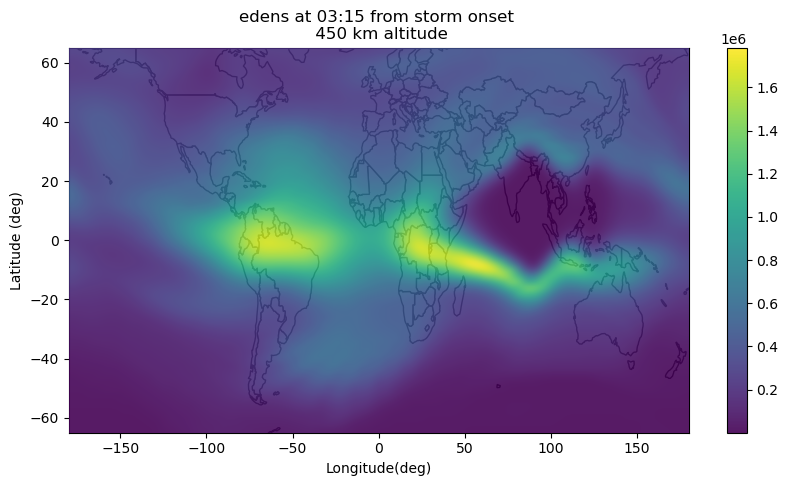

/home/axb170054/scratch/made_plots/SimStormPaper/SAMI/maps/edens/raw/450/075.png


In [23]:
call_maps('edens', times[75], 450, figtype = 'raw', save_or_show = 'show')

In [328]:
loop_maps(plottype = 'diff')

making maps!:   0%|          | 0/30240 [00:00<?, ?it/s]

In [325]:
loop_keos(plottype='diff')

making keos!:   0%|          | 0/1470 [00:00<?, ?it/s]